# Time-frequency behaviour

We are still looking at the two stream instability investigated in [Hawke, Andersson and Comer (2013)](http://dx.doi.org/10.1088/0264-9381/30/14/145007) - see the paper, `Figure1.ipynb` and `InstabilityAnimation.ipynb` for details. Here we are interested in the growth rate of the different modes with time - again we will only look at the linearized solution. Essentially we are reproducing parts of Figure 6 from the paper here.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})

In [4]:
import EOS
import compute_perturbation as mf

# EOS options.
options_unstable = dict([('EOS_Derivatives', EOS.EOS_Paper), \
                         ('kappa', [0.5, 0.5])             , \
                         ('kappa_12', 0.0)                 , \
                         ('kappa_delta', 0.5)              , \
                         ('gamma', [1.6, 1.8])             , \
                         ('m', [1.0, 1.0])                 , \
                         ('sigma', [0.0, 0.0])])

# Domain
options_unstable['L'] = 1.0
options_unstable['a_max'] = 128

# Background
rho_bg = 1.0
v_bg1  = 0.0
W_bg1  = 1.0 / np.sqrt(1.0 - v_bg1**2)
v_bg2  = 0.6
W_bg2  = 1.0 / np.sqrt(1.0 - v_bg2**2)
options_unstable['n_bg'] = np.array([[rho_bg * W_bg1,  rho_bg * W_bg1 * v_bg1], \
                                     [rho_bg * W_bg2,  rho_bg * W_bg2 * v_bg2]])

# Perturbation - single sine wave
d_n = 1.0e-5
d_v = 0.0
W = 1.0 / np.sqrt(1.0 - d_v**2)
delta_nhat = np.zeros((options_unstable['a_max'], 2, 2), complex)
delta_nhat[0, 0, 0] = -0.5 * 1j * W * d_n
delta_nhat[0, 0, 1] = -0.5 * 1j * W * d_n * d_v
# This part adds adjusted floating point noise.
for a in range(1, options_unstable['a_max']):
    delta_nhat[a, :, 0] += 1e-22 * 1j
options_unstable['delta_nhat'] = delta_nhat

# Now set up the time domain
t_unstable = np.linspace(0.0, 2.0, 51)

# Now the frequency space solution
FFT_linear = np.zeros((len(t_unstable), options_unstable['a_max']))
for a in range(1, options_unstable['a_max']):
    inv_L_delta_F = mf.calc_inv_L_delta_F(t_unstable, a, options_unstable)
    FFT_linear[:, a-1] = np.log10(np.maximum(np.abs(inv_L_delta_F[:, 0, 0]), 1.e-16))

# Now with the adjusted omega to account for the numerical differencing error.
options_adjusted = options_unstable.copy()
omega = np.pi * np.arange(options_adjusted['a_max']) / (options_adjusted['L'] * options_adjusted['a_max'])
omega_prime = (8.0 * np.sin(omega) - 2.0 * np.sin(2.0 * omega)) / 6.0 * options_adjusted['a_max']
options_adjusted['omega'] = omega_prime
# Now the adjusted frequency space solution
FFT_linear_adjusted = np.zeros((len(t_unstable), options_adjusted['a_max']))
for a in range(1, options_adjusted['a_max']):
    inv_L_delta_F_adjusted = mf.calc_inv_L_delta_F(t_unstable, a, options_adjusted)
    FFT_linear_adjusted[:, a-1] = np.log10(np.maximum(np.abs(inv_L_delta_F_adjusted[:, 0, 0]), 1.e-16))

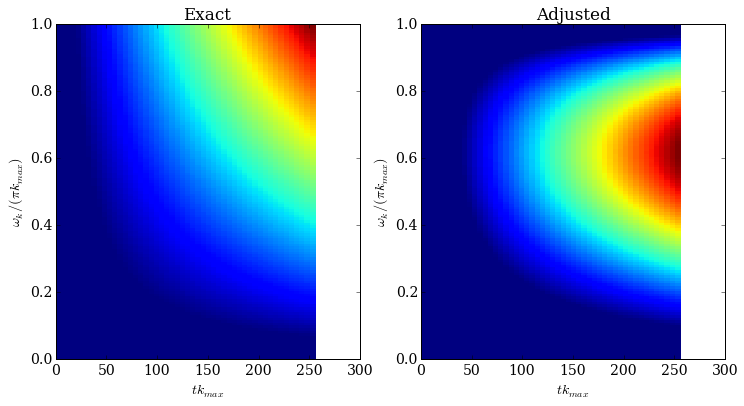

In [5]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.pcolor(t_unstable * options_unstable['a_max'], \
           np.linspace(0.0, 1.0, options_unstable['a_max']), \
           FFT_linear.T)
ax1.set_xlabel("$t k_{max}$")
ax1.set_ylabel("$\omega_k / (\pi k_{max})$")
ax1.set_title("Exact")
ax2 = fig.add_subplot(1,2,2)
ax2.pcolor(t_unstable * options_adjusted['a_max'], \
           np.linspace(0.0, 1.0, options_adjusted['a_max']), \
           FFT_linear_adjusted.T)
ax2.set_xlabel("$t k_{max}$")
ax2.set_ylabel("$\omega_k / (\pi k_{max})$")
ax2.set_title("Adjusted")
plt.show()